# Multi-cellular transport
## Integration of membrane protein and transport of substrates between multiple cellular compartments using BioCRNpyler membrane components and transport mechanisms
All the examples below show the use of the membrane transport mechanism of Simple Diffusion, Simple Transport, Facilitated Transport, and Primary Active Transport occurring between two cells sharing the same external environment. Although each example uses the exact transport mechanism, the mechanisms used do not have to be the same. However, the membrane protein cannot start from DNA in both cells for this multi-cellular transport to function correctly. The compartment of the monomer needs to be indicated when expressing the membrane protein from DNA.

### Packages

In [1]:
from biocrnpyler import *
import numpy as np
%matplotlib inline
import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()
from bokeh.themes import Theme
from bokeh.layouts import row

# Modules needed from Bokeh.
from bokeh.io import output_file, show
from bokeh.plotting import gridplot,figure
from bokeh.models import LinearAxis, Range1d
color=bokeh.palettes.Accent[6]
    
from bokeh.io import export_png

Loading BokehJS ...

In [2]:
# Function with some standard Bokeh plot settings
def create_custom_plot(title_text, x_max=8,y_max=2, yname=None):
    custom_plot = figure(
        toolbar_location='right',
        outline_line_color=None,
        min_border_right=10,
        height=400,
        width=400,
    )

    custom_plot.title.text = title_text
    custom_plot.xaxis.axis_label = 'Time (hours)'
    custom_plot.yaxis.axis_label = yname
    custom_plot.y_range = Range1d(0, y_max)
    custom_plot.x_range = Range1d(0, x_max)
    custom_plot.outline_line_color = None

    # custom_plot.yaxis
    custom_plot.ygrid.visible = False
    custom_plot.yaxis.axis_label_text_font_size = '15pt'
    custom_plot.yaxis.major_label_text_font_size = '15pt'
    custom_plot.yaxis.major_label_text_font = 'Work Sans'
    custom_plot.yaxis.axis_label_standoff = 15
    custom_plot.yaxis.axis_label_text_font_style = 'normal'

    # custom_plot.xaxis
    custom_plot.xgrid.visible = False
    custom_plot.xaxis.axis_label_text_font_size = '15pt'
    custom_plot.xaxis.major_label_text_font_size = '15pt'
    custom_plot.xaxis.major_label_text_font = 'Work Sans'
    custom_plot.xaxis.axis_label_standoff = 15
    custom_plot.xaxis.axis_label_text_font_style = 'normal'

    # custom_plot.title
    custom_plot.title.text_font_size = '18pt'
    custom_plot.title.align = 'left'
    custom_plot.title.offset = -50.0

    return custom_plot

# Example 0: Simple diffusion across multiple compartments
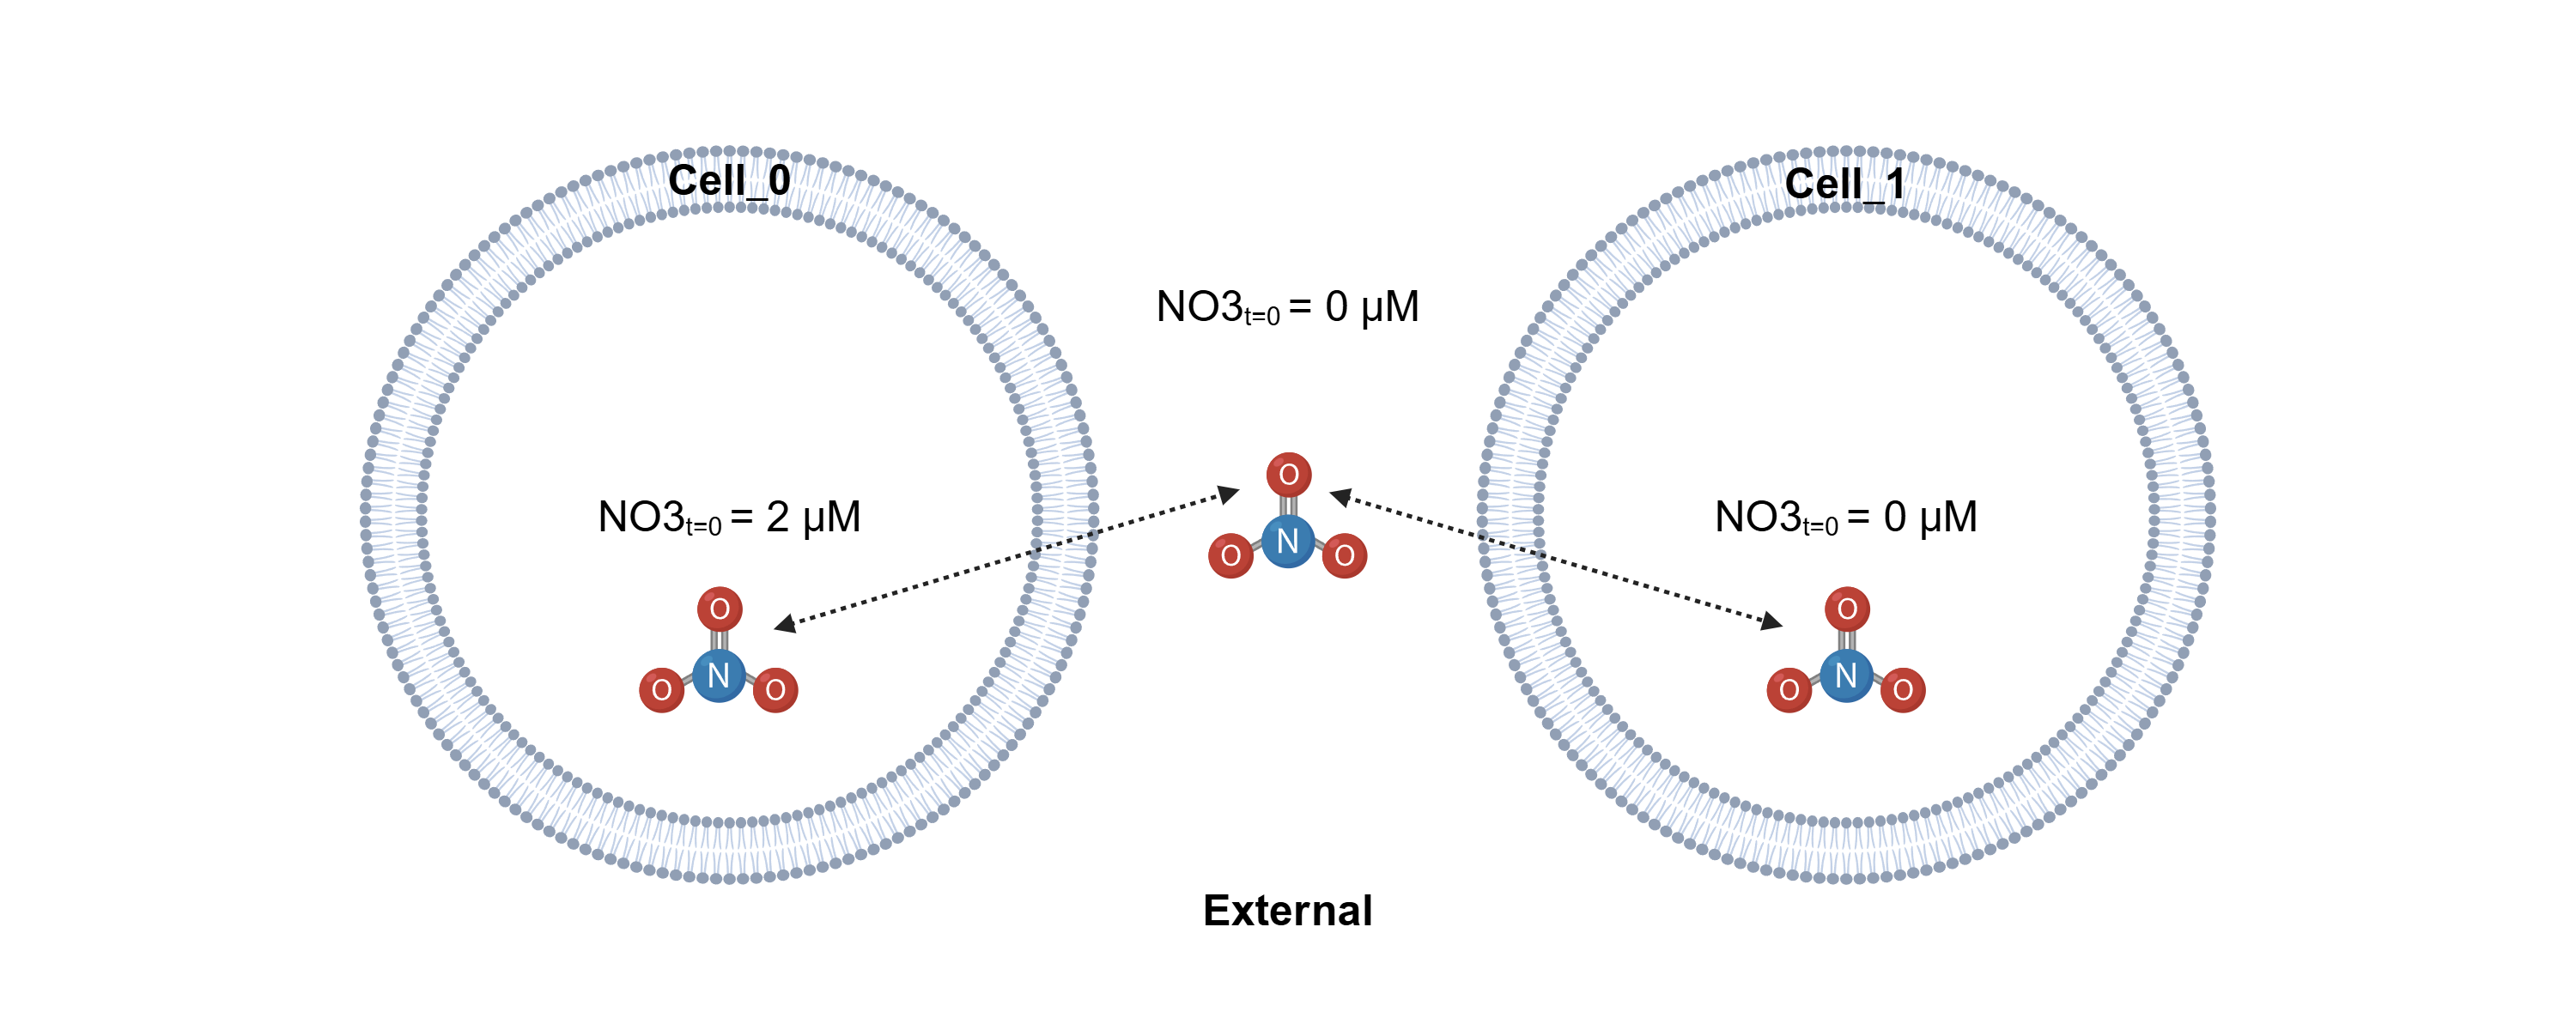
Consider the following diffusion step:
1. Diffusion of small molecules (i.e. Nitrate):
\begin{align}
    NO3_{internal_0} \rightleftharpoons NO3_{external} \rightleftharpoons NO3_{internal_1}
\end{align}

## Cell 0

In [3]:
NO3=DiffusibleMolecule('NO3', cell='0')

default_parameters = {"k_diff":2e-4}
mech_cat = Simple_Diffusion() 

default_mechanisms = {mech_cat.mechanism_type:mech_cat}
M1= Mixture("Cell0", components = [NO3], parameters = default_parameters, mechanisms = default_mechanisms)
CRN0 = M1.compile_crn()

## Cell 1

In [4]:
NO3=DiffusibleMolecule('NO3', cell='1')

default_parameters = {"k_diff":2e-4}
mech_cat = Simple_Diffusion() 

default_mechanisms = {mech_cat.mechanism_type:mech_cat}
M2= Mixture("Cell1", components = [NO3], parameters = default_parameters, mechanisms = default_mechanisms)
CRN1 = M2.compile_crn()

## Combine models

In [5]:
addReactions= CRN1.reactions
addSpecies= CRN1.species

CRN0.add_species(addSpecies)
CRN0.add_reactions(addReactions)

In [6]:
# Simulate CRN
try:
    import bioscrape
    import bokeh
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')
else:
    from biocrnpyler import *
    import numpy as np
    import pandas as pd
    maxtime = 300000
    timepoints = np.arange(0, maxtime, 100)
    
    #Inital conditions
    x0_dict= {'NO3_Internal_0':2}
    
    #Run Simulation
    R = CRN0.simulate_with_bioscrape_via_sbml(timepoints = timepoints, initial_condition_dict = x0_dict)
    
    #Plot NO3 diffusion
    pNO3 =create_custom_plot("NO3 Diffusion", x_max=8,y_max= 2, yname='NO3 (uM)')
    pNO3.line(R["time"]/3600,  R['NO3_Internal_0'], line_width = 3, color=color[0], legend_label='Internal_0')
    pNO3.line(R["time"]/3600,  R['NO3_Internal_1'], line_width = 3, color=color[1],legend_label='Internal_1')
    pNO3.line(R["time"]/3600,  R['NO3_External'], line_width = 3, color=color[2],legend_label='External',line_dash = 'dashed')
    
    # Display the layout
    pNO3.legend.click_policy="hide"
    show(pNO3)

# Example 1: Simple transport across multiple compartments
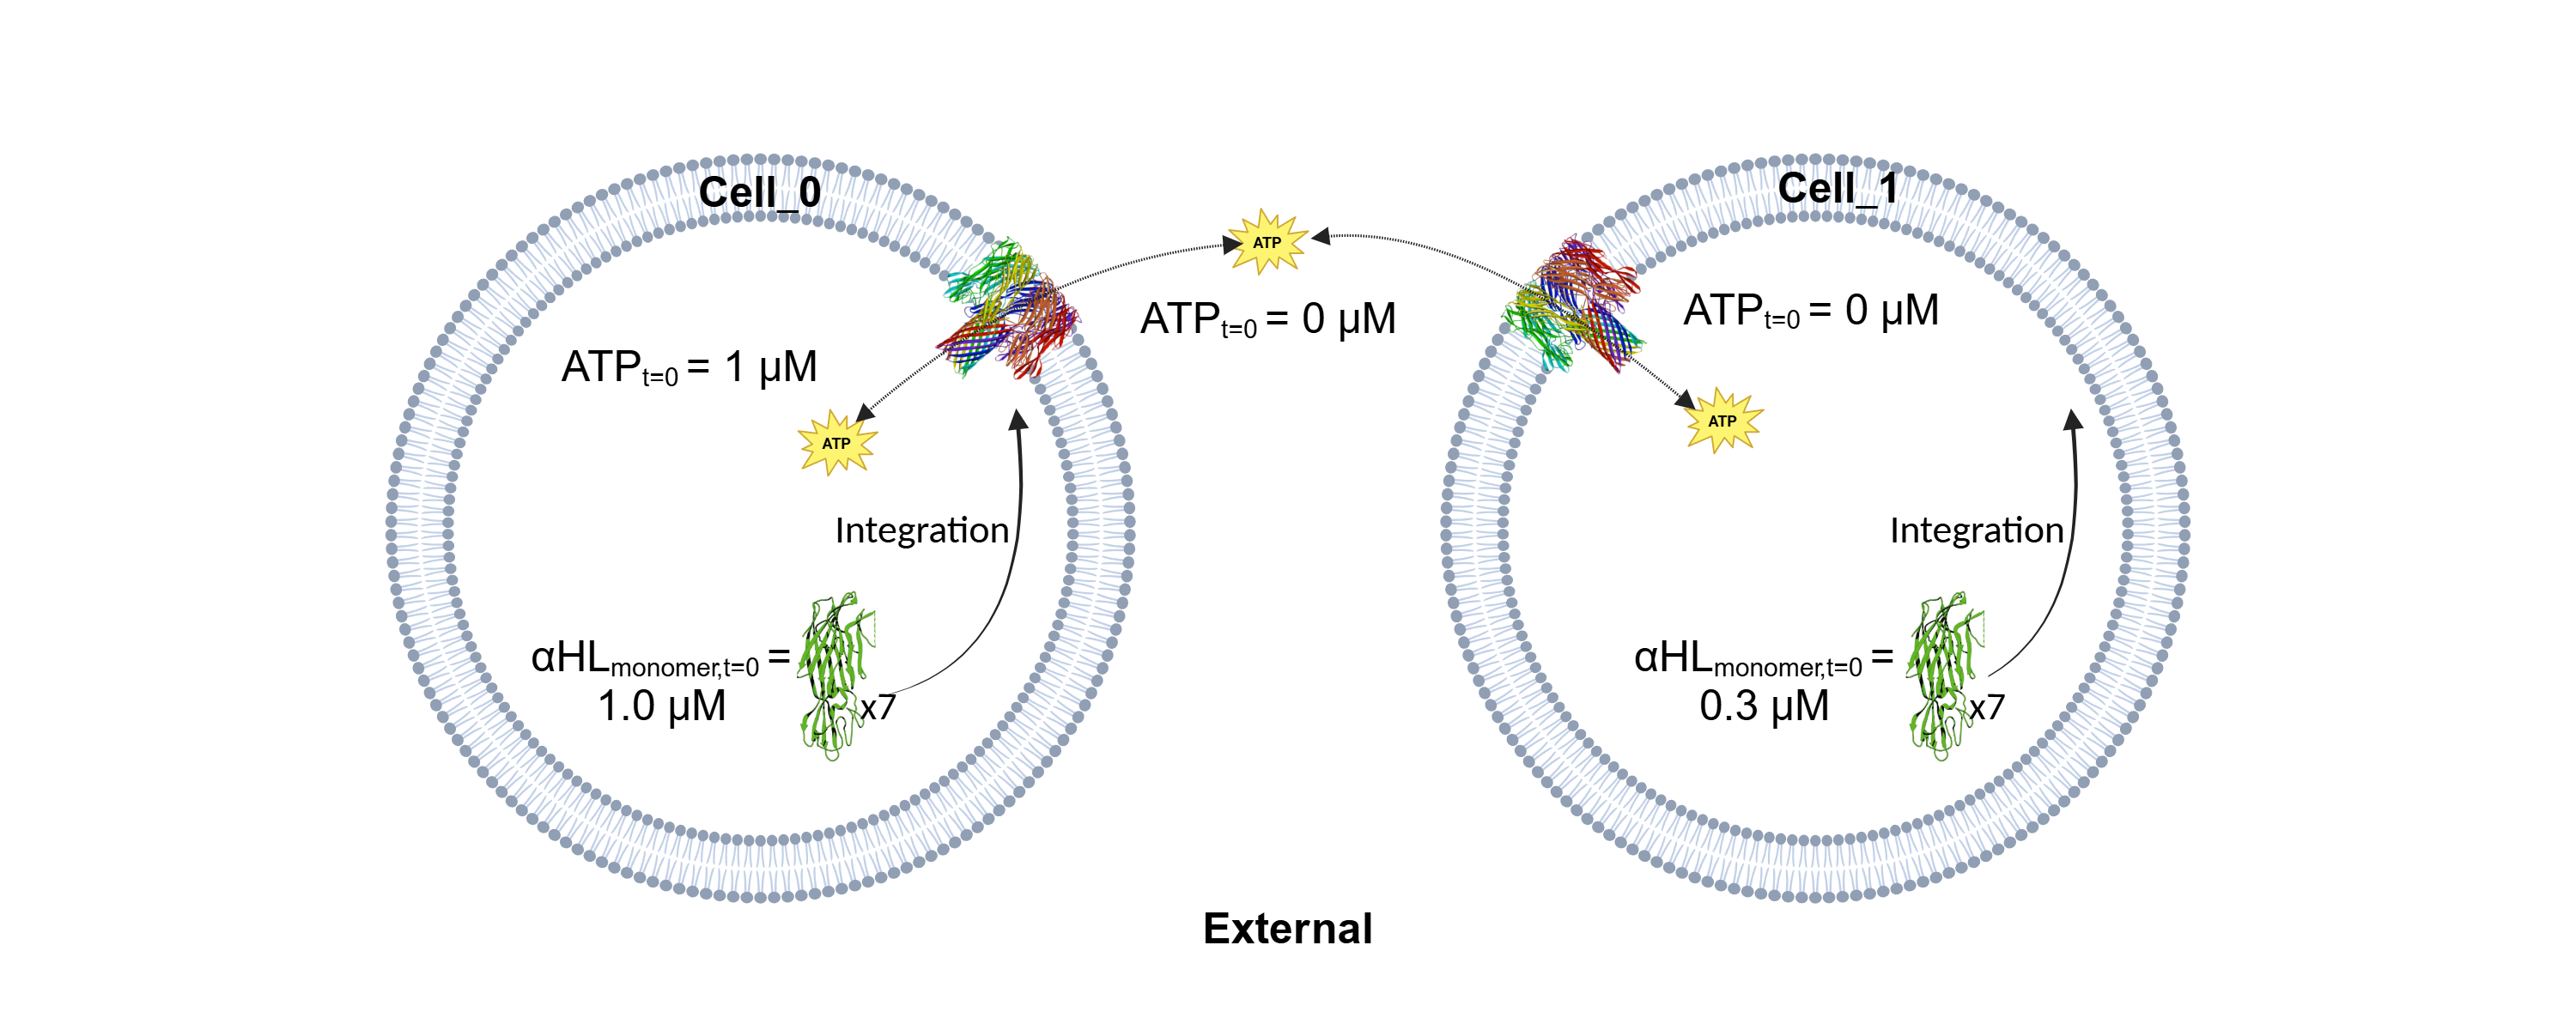
Consider the following substrate transport steps for each cell:
1. Assemble into a homoheptamer:
\begin{align}
    7\alpha HL_{monomer} \rightarrow \alpha HL_{homoheptamer}
\end{align}
2. Integration of membrane protein in membrane:
\begin{align}
    \alpha HL_{homoheptamer} \rightarrow \alpha HL_{channel}.
\end{align}

Followed by the transport reactions specific to each cell:

3. Diffusion of small molecules (i.e. ATP) across membrane:
\begin{align}
    ATP_{internal_0} +\alpha HL_{channel_0} \rightleftharpoons ATP_{external}+\alpha HL_{channel_0}\\
   ATP_{internal_1} +\alpha HL_{channel_1} \rightleftharpoons ATP_{external}+\alpha HL_{channel_1}
\end{align}

## Cell 0

### Identify the membrane protein monomer

In [7]:
#Identify the membrane protein monomer
alphaHL_monomer = IntegralMembraneProtein('alphaHL_monomer', product='alphaHL', size=7, cell=0)

## Parameters
int_parameters = {"kb1":2e-3, "ku1": 2e-10 ,"kcat":10, "kex":.5,"kb2":5 }

##Mechanism
mech_int = Membrane_Protein_Integration() 
int_mechanisms = {mech_int.mechanism_type:mech_int}

##Make Mixture
M1_c0= Mixture("Integration_Cell0", components = [alphaHL_monomer], parameters = int_parameters, mechanisms = int_mechanisms)
##Compile the CRN
CRN1_cell0 = M1_c0.compile_crn()

### Define membrane channel and transport mechanism

In [8]:
## Define membrane channel and transport mechanism
alphaHL_channel=MembraneChannel(alphaHL_monomer.product, substrate='ATP',)

## Parameters
trans_parameters = {"k_trnsp":1.2e-2}

## Mechanism
mech_tra = Simple_Transport()
tra_mechanisms = {mech_tra.mechanism_type:mech_tra}

## Make Mixture
M2_c0= Mixture("Channel_Cell0", components = [alphaHL_channel], parameters = trans_parameters, mechanisms = tra_mechanisms)

##Compile the CRN
CRN2_cell0 = M2_c0.compile_crn()

## Cell 1

In [9]:
## Identify the membrane protein monomer
alphaHL_monomer = IntegralMembraneProtein('alphaHL_monomer', product='alphaHL', size=7, cell=1)

##Make Mixture 1
M1_c1= Mixture("Integration_Cell1", components = [alphaHL_monomer], parameters = int_parameters, mechanisms = int_mechanisms)
##Compile the CRN
CRN1_cell1 = M1_c1.compile_crn()

## Define membrane channel and transport mechanism
alphaHL_channel=MembraneChannel(alphaHL_monomer.product, substrate='ATP',)

## Make Mixture 2
M2_c1= Mixture("Channel_Cell1", components = [alphaHL_channel], parameters = trans_parameters, mechanisms = tra_mechanisms)

##Compile the CRN
CRN2_cell1 = M2_c1.compile_crn()

## Combine these CRNs

In [10]:
Reactions= CRN1_cell0.reactions+CRN2_cell0.reactions+CRN1_cell1.reactions+CRN2_cell1.reactions
Species= CRN1_cell0.species+CRN2_cell0.species+CRN1_cell1.species+CRN2_cell1.species

#Make a CRN
CRN = ChemicalReactionNetwork(species = Species, reactions = Reactions)

In [11]:
# Simulate CRN
try:
    import bioscrape
    import bokeh
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')
else:
    from biocrnpyler import *
    import numpy as np
    import pandas as pd
    maxtime = 300000
    timepoints = np.arange(0, maxtime, 100)
    
    #Inital conditions
    x0_dict= {'ATP_Internal_1':1,'protein_alphaHL_monomer_Internal_1':.5,'protein_alphaHL_monomer_Internal_0':.3,}
    
    #Run Simulation
    R = CRN.simulate_with_bioscrape_via_sbml(timepoints = timepoints, initial_condition_dict = x0_dict)
    
    #Plot the transport of substrate ATP
    paHL =create_custom_plot("Simple Transport of ATP", x_max=8,y_max= 1, yname='ATP (uM)')
    paHL.line(R["time"]/3600,  R['ATP_Internal_0'], line_width = 3, legend_label = "Internal_0", color =  color[0])
    paHL.line(R["time"]/3600,  R['ATP_Internal_1'], line_width = 3, legend_label = "Internal_1", color =  color[1])
    paHL.line(R["time"]/3600,  R['ATP_External'], line_width = 3, legend_label = "Enternal", color = color[2], line_dash = 'dashed')
    
    #Show Figure
    paHL.legend.click_policy="hide"
    show(paHL)

# Example 2:  Facilitated transport across multiple compartments
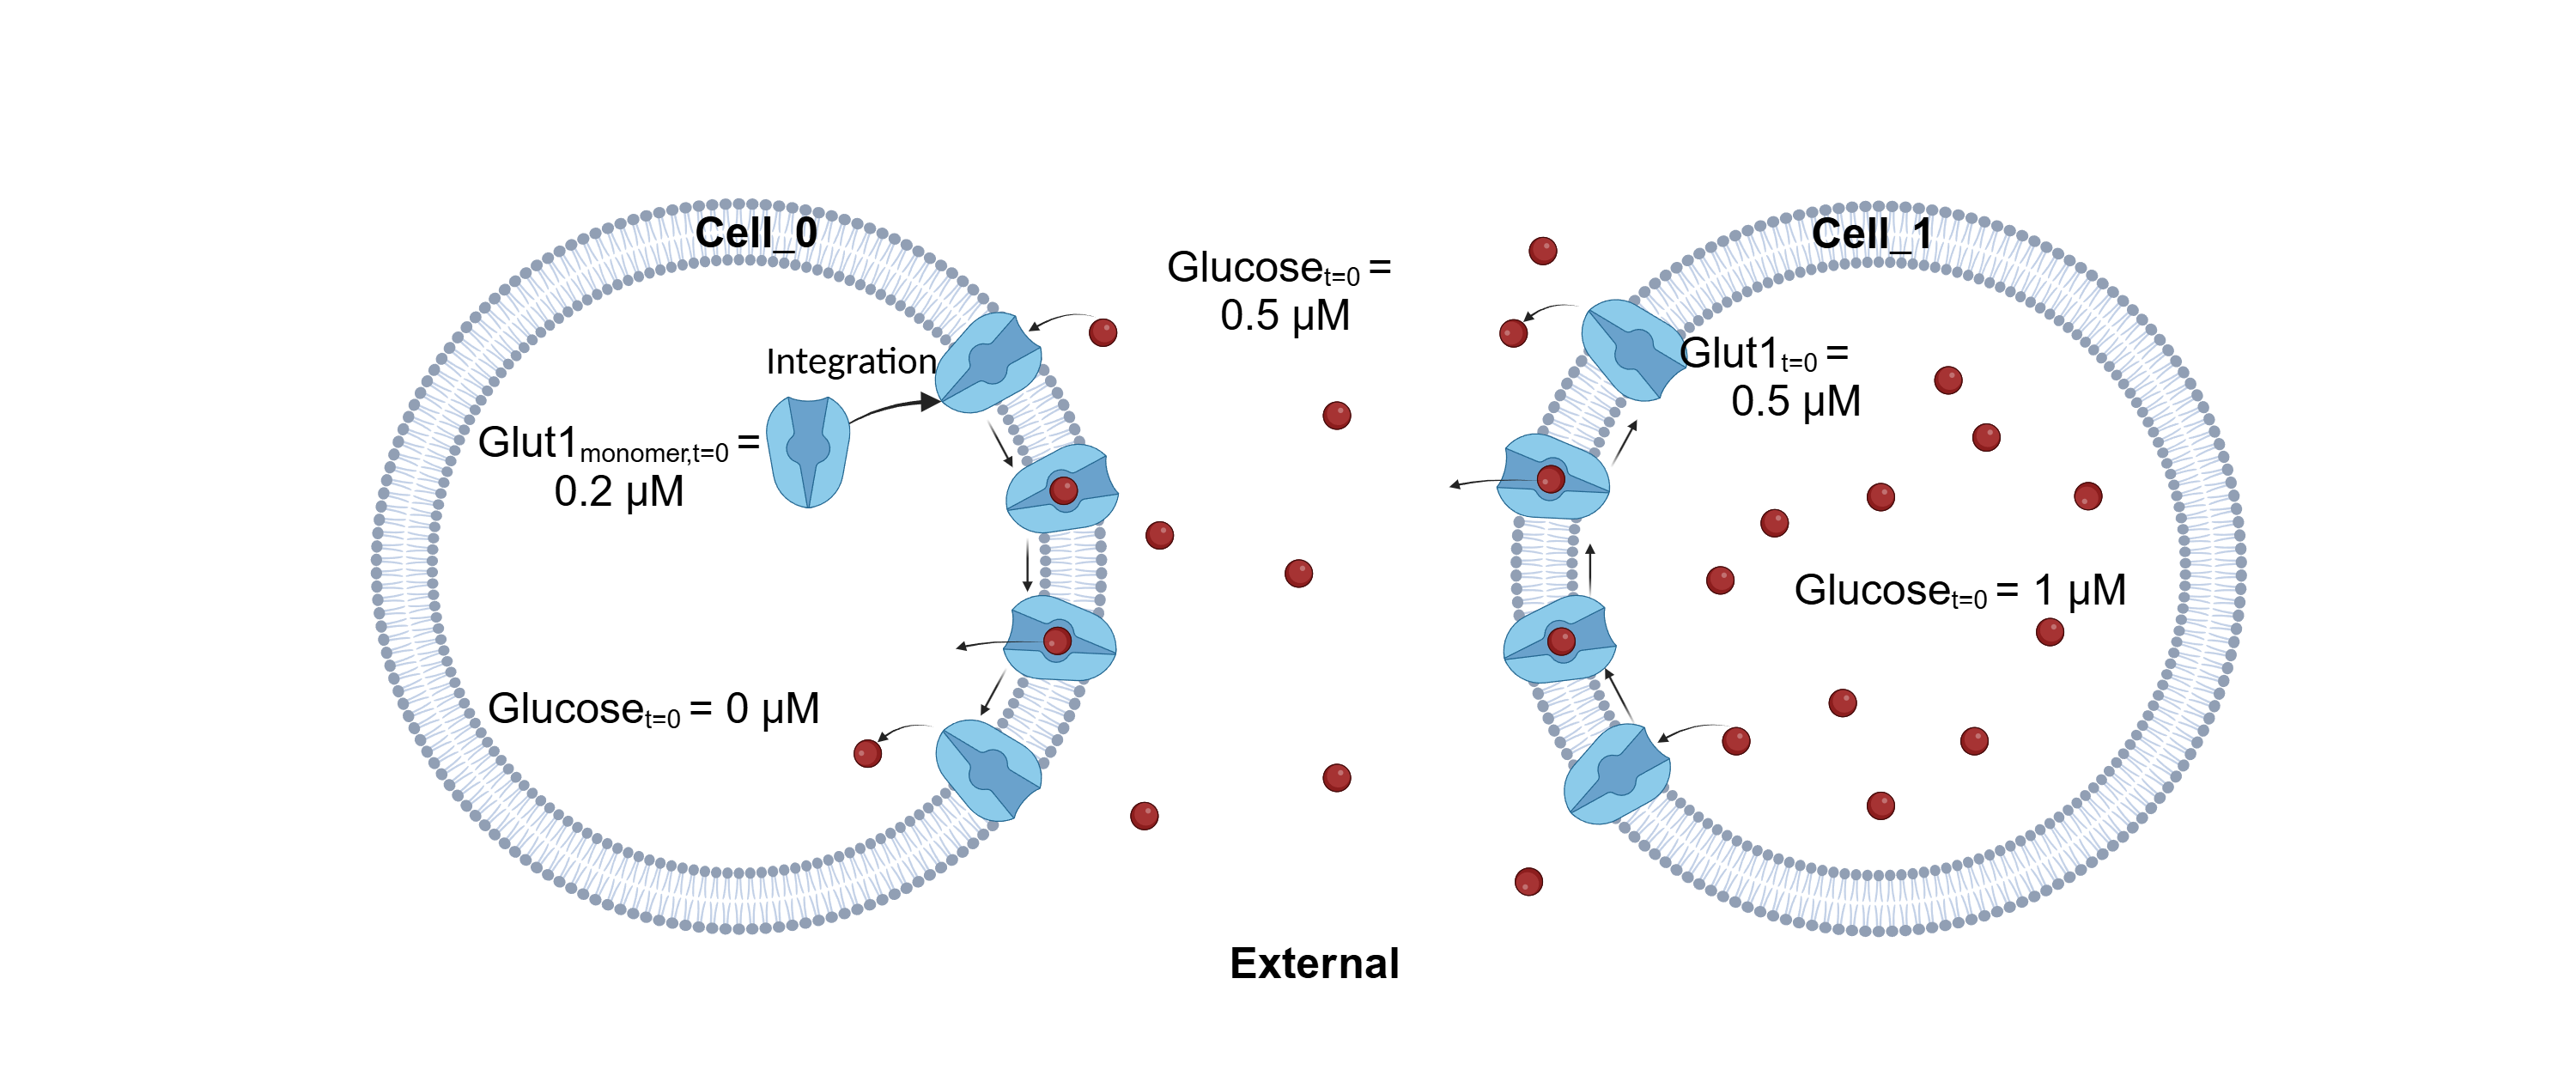
In this example, the membrane channel is found in two different orientations: native orientation in Cell_0 and inverted orientation in Cell_1, thus acting as an exporter.

Consider the following substrate transport steps for cell_0:
1. Integration of membrane protein in membrane:
\begin{align}
    GLUT1_{monomer} \rightarrow GLUT1_{channel_0}
\end{align}

while Glut1 in Cell_1 is modeled as an incorporated membrane channel. Without going into all the reactions of the Glut1 transport of glucose in Cell_1 the overarching reaction is: 
\begin{align}
   glucose_{internal_1} + GLUT1_{channel_1} \longrightarrow  GLUT1_{channel_1} + glucose_{external}. \\
\end{align}

Then glucose exported by Cell_1 is then imported by Cell_0 following the simplified reaction:
\begin{align}
    glucose_{external} + GLUT1_{channel_0}  \longrightarrow GLUT1_{channel_0} + glucose_{internal_0}. \\
\end{align}

## Cell 0

### Identify the membrane protein monomer

In [12]:
#Identify the membrane protein monomer
glut1 = IntegralMembraneProtein('glut1', product='glut1_channel', direction='Importer', size= 1, cell=0)

## Parameters
int_parameters = {"kd1":5,"kb1":2e-3, "ku1": 2e-10 ,"kcat":10, "kex":.5,"kd2":5 }

##Mechanism
mech_int = Membrane_Protein_Integration()
int_mechanisms = {mech_int.mechanism_type:mech_int}

##Make Mixture
M1_c0= Mixture("Integration_Cell0", components = [glut1], parameters = int_parameters, mechanisms = int_mechanisms)
##Compile the CRN
CRN1_cell0 = M1_c0.compile_crn()

### Define membrane channel and transport mechanism

In [13]:
## Define membrane channel and transport mechanism
glut1_channel=MembraneChannel(glut1.product, substrate='glucose')

## Parameters
trans_parameters = {"k_trnsp":1e-3, "ku1":1e-2,"ku2":1e-2, "k1":1e-2}

## Mechanism
mech_tra = Facilitated_Transport_MM()
tra_mechanisms = {mech_tra.mechanism_type:mech_tra}

## Make Mixture
M2_c0= Mixture("Channel_Cell0", components = [glut1_channel], parameters = trans_parameters, mechanisms = tra_mechanisms)

##Compile the CRN
CRN2_cell0 = M2_c0.compile_crn()

## Cell 1

In [14]:
#Identify the membrane protein monomer
glut1 = IntegralMembraneProtein('glut1', product='glut1_channel', direction='Exporter', size= 1, cell=1)

##Make Mixture
M1_c1= Mixture("Integration_Cell1", components = [glut1], parameters = int_parameters, mechanisms = int_mechanisms)
##Compile the CRN
CRN1_cell1 = M1_c1.compile_crn()

## Define membrane channel and transport mechanism
glut1_channel=MembraneChannel(glut1.product, substrate='glucose')

## Make Mixture
M2_c1= Mixture("Channel_Cell1", components = [glut1_channel], parameters = trans_parameters, mechanisms = tra_mechanisms)

##Compile the CRN
CRN2_cell1 = M2_c1.compile_crn()

## Combine these CRNs

In [15]:
Reactions= CRN1_cell0.reactions+CRN2_cell0.reactions+CRN1_cell1.reactions+CRN2_cell1.reactions
Species= CRN1_cell0.species+CRN2_cell0.species+CRN1_cell1.species+CRN2_cell1.species

#Make a CRN
CRN = ChemicalReactionNetwork(species = Species, reactions = Reactions)

In [16]:
# Simulate CRN
try:
    import bioscrape
    import bokeh
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')
else:
    from biocrnpyler import *
    import numpy as np
    import pandas as pd
    maxtime = 300000
    timepoints = np.arange(0, maxtime, 100)
    
    #Inital conditions
    x0_dict= {'glucose_Internal_1': 1, 'glucose_External': 0.5,
              'protein_glut1_Internal_0':.2,
              'protein_glut1_channel_Exporter_Membrane_1':.5,}
    
    #Run Simulation
    R = CRN.simulate_with_bioscrape_via_sbml(timepoints = timepoints, initial_condition_dict = x0_dict)
    
    #Plot the transport of substrate ATP
    pglut =create_custom_plot("Facilitated Transport of Glucose", x_max=8,y_max= 1, yname='Glucose (uM)')
    pglut.line(R["time"]/3600,  R['glucose_Internal_0'], line_width = 3, legend_label = "Internal_0", color =  color[0])
    pglut.line(R["time"]/3600,  R['glucose_Internal_1'], line_width = 3, legend_label = "Internal_1", color =  color[1])
    pglut.line(R["time"]/3600,  R['glucose_External'], line_width = 3, legend_label = "External", color = color[2], line_dash = 'dashed')
    
    #Show Figure
    pglut.legend.click_policy="hide"
    show(pglut)

# Example 3: Active transport across multiple compartments
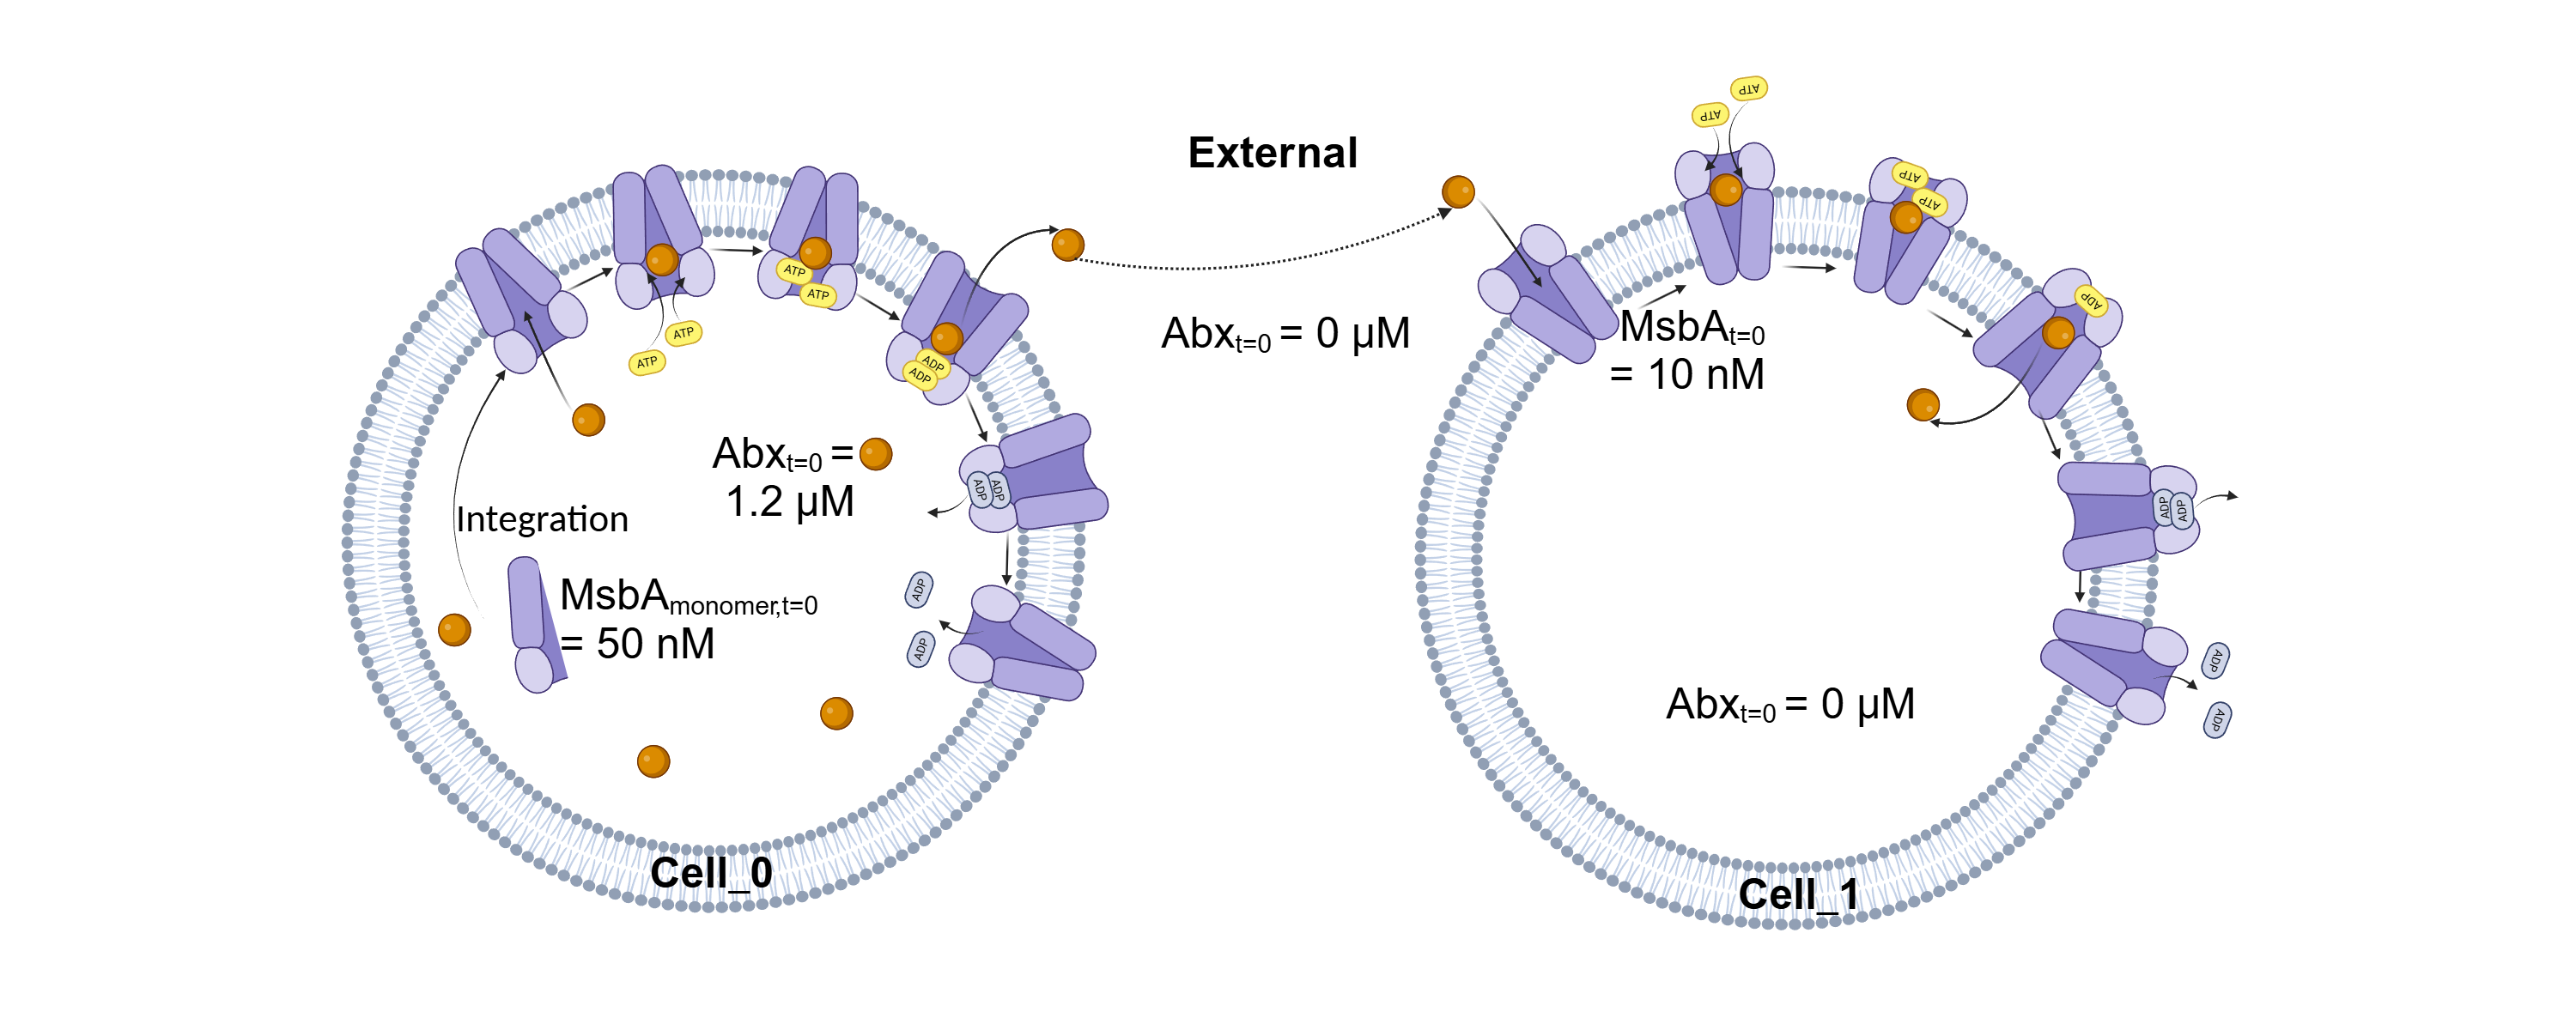
In this example, the membrane pump is found in two different orientations: native orientation in Cell_0 and inverted orientation in Cell_1, thus acting as an importer.

Consider the following substrate transport steps for cell_1:
1. Assemble into a homodimer:
\begin{align}
    2MsbA_{monomer} \rightarrow MsbA_{homodimer}
\end{align}
2. Integration of membrane protein in membrane:
\begin{align}
    MsbA_{homodimer} \rightarrow MsbA_{exporter_0}
\end{align}

while MsbA in Cell_1 is modeled as an incorporated membrane pump. Without going into all the reactions of the MsbA transport of Abx in Cell_0 the overarching reaction is: 
\begin{align}
    Abx_{internal_0} + MsbA_{exporter_0} + 2ATP_{internal_0} \longrightarrow 2ADP_{internal_0} + MsbA_{exporter_0} + Abx_{external}. \\
\end{align}
Then Abx exported by Cell_0 is then imported by Cell_1 following the simplified reaction:
\begin{align}
   Abx_{external} + MsbA_{exporter_1} + 2ATP_{external} \longrightarrow 2ADP_{external} + MsbA_{exporter_1} + Abx_{internal_1}. \\
\end{align}

## Cell 0

### Identify the membrane protein monomer

In [17]:
#Identify the membrane protein monomer
MsbA_monomer = IntegralMembraneProtein('MsbA_monomer', product='MsbA_pump', direction='Exporter', size= 2, cell=0)

## Parameters
int_parameters =  {"kb1":2e-3, "ku1": 2e-10 ,"kcat":10, "kex":.5,"kb2":5 }

##Mechanism
mech_int = Membrane_Protein_Integration()
int_mechanisms = {mech_int.mechanism_type:mech_int}

##Make Mixture
M1_c0= Mixture("Integration_Cell0", components = [MsbA_monomer], parameters = int_parameters, mechanisms = int_mechanisms)
##Compile the CRN
CRN1_cell0 = M1_c0.compile_crn()

### Define membrane channel and transport mechanism

In [18]:
## Define membrane channel and transport mechanism
MsbA_pump=MembranePump(MsbA_monomer.product, substrate='Abx',ATP=2)

## Parameters
trans_parameters = {"k1":1e-1, "ku1":0.1, "k2":1e-1, "ku2":1e-2,
                      "k_trnsp":1e-2,"ku3":.1,"ku4":.1,}

## Mechanism
mech_tra = Primary_Active_Transport_MM()
tra_mechanisms = {mech_tra.mechanism_type:mech_tra}

## Make Mixture
M2_c0= Mixture("Channel_Cell0", components = [MsbA_pump], parameters = trans_parameters, mechanisms = tra_mechanisms)

##Compile the CRN
CRN2_cell0 = M2_c0.compile_crn()

## Cell 1

In [19]:
#Identify the membrane protein monomer
MsbA_monomer = IntegralMembraneProtein('MsbA_monomer', product='MsbA_pump', direction='Importer', size= 2, cell=1)

##Make Mixture
M1_c1= Mixture("Integration_Cell1", components = [MsbA_monomer], parameters = int_parameters, mechanisms = int_mechanisms)
##Compile the CRN
CRN1_cell1 = M1_c1.compile_crn()

## Define membrane channel and transport mechanism
MsbA_pump=MembranePump(MsbA_monomer.product, substrate='Abx',ATP=2)

## Make Mixture
M2_c1= Mixture("Channel_Cell1", components = [MsbA_pump], parameters = trans_parameters, mechanisms = tra_mechanisms)

##Compile the CRN
CRN2_cell1 = M2_c1.compile_crn()

## Combine these CRNs

In [20]:
Reactions= CRN1_cell0.reactions+CRN2_cell0.reactions+CRN1_cell1.reactions+CRN2_cell1.reactions
Species= CRN1_cell0.species+CRN2_cell0.species+CRN1_cell1.species+CRN2_cell1.species

#Make a CRN
CRN = ChemicalReactionNetwork(species = Species, reactions = Reactions)

In [21]:
# Simulate CRN
try:
    import bioscrape
    import bokeh
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')
else:
    from biocrnpyler import *
    import numpy as np
    import pandas as pd
    maxtime = 300000
    timepoints = np.arange(0, maxtime, 100)
    
    #Inital conditions
    x0_dict= {'Abx_Internal_0':1.2,
              'small_molecule_ATP_Internal_0':100,'protein_MsbA_monomer_Internal_0':.05,
              'small_molecule_ATP_External':100,'protein_MsbA_pump_Importer_Membrane_1':.01}
    
    #Run Simulation
    R = CRN.simulate_with_bioscrape_via_sbml(timepoints = timepoints, initial_condition_dict = x0_dict)
    
    #Plot the transport of substrate Abx
    pAbx =create_custom_plot("Active Transport of Abx", x_max=8,y_max= 2, yname='Abx (uM)')
    pAbx.line(R["time"]/3600,  R['Abx_Internal_0'], line_width = 3, legend_label = "Internal_0", color = color[0],)
    pAbx.line(R["time"]/3600,  R['Abx_Internal_1'], line_width = 3, legend_label = "Internal_1", color = color[1],)
    pAbx.line(R["time"]/3600,  R['Abx_External'], line_width = 3, legend_label = "External", color = color[2], line_dash = 'dashed')
    
    #Show Figure
    pAbx.legend.click_policy="hide"
    show(pAbx)